# Model Selection

In [2]:
!pip install prettytable

  Using cached prettytable-3.11.0-py3-none-any.whl.metadata (30 kB)
Using cached prettytable-3.11.0-py3-none-any.whl (28 kB)


## 1.Import Dependencies

In [254]:
import re
import os
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# regression
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
# naive bayes
from sklearn.naive_bayes import MultinomialNB
# support vector
from sklearn.svm import SVC
# decision tree
from sklearn.tree import DecisionTreeClassifier
# ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier

# k neighbour
from sklearn.neighbors import KNeighborsClassifier

# stats
import statsmodels.api as sm
from scipy.stats import boxcox # this can't handle negative values
from scipy.stats import yeojohnson # this ia extention to boxcox

# encoder and scaling
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

# from pycaret.classification import *
import optuna
from typing import List, Optional
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# -- utility --
from prettytable import PrettyTable
from tqdm import tqdm
import warnings
import mlflow
import os
os.getcwd()
warnings.filterwarnings('ignore')

## 2. Utility Functions

In [255]:
def confusion_matrix_and_roc_curve_plot(true: List, predicted: List, probabilities: List, label_dict: dict()):
  """
  this function plots confusion matrix and Roc curev for model
  """
  try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # -------- Confusion matrix plot --------
    cm = confusion_matrix(true, predicted)

    # Heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values(), ax=axes[0])

    # Labels and title
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')
    axes[0].set_title(f'Confusion Matrix\nF1 Score (weighted): {f1_score(true, predicted, average="weighted")}')


    # -------- ROC Curve --------
        # Binarize the output
    y = label_binarize(true, classes=[i for i in range(len(label_dict.keys()))])
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw= 2
    # Plot all ROC curves
    axes[1].plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    axes[1].plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "blue"])
    for i, color in zip(range(n_classes), colors):
        axes[1].plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class: {0} (area = {1:0.2f})".format( label_dict[i], roc_auc[i]),
        )

    axes[1].plot([0, 1], [0, 1], "k--", lw=lw)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("Receiver operating characteristic to multiclass")
    axes[1].legend(loc="lower right")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

  except Exception as e:
    print(f"Error: {e}")

In [256]:
def context_length_wise_precision(df: pd.DataFrame, predictions: List, bins:int = 100):
  """
    this function categorizes text based on token lengths of text, then
    compares the context length bins bar vs model precision, using this
    plot we can under stand models context understanding power.

    Args:
      bins (int) : size of each bin
  """
  try:
    # bins = 100 # size of a bins
    min = 0
    max = df["token_length"].max()

    # bin labels (x-axis)
    categories = [i for i in range(bins, max+bins, bins)]
    # adding predictions to dataframe
    df["pred"] = predictions

    # calculating bin frequency and true positive count
    actual_freq = []
    true_positive_for_bin = []

    # Get the unique classes in y_true
    classes = df['Label'].unique()

    for i in range(min, max, bins):
      dummy_df = df[(df["token_length"] > i) & (df["token_length"] <= i+bins)].copy()
      # collecting count for bin
      actual_freq.append(dummy_df.shape[0])
      # Loop through each class and calculate True Positives (TP) count
      TP = 0
      for cls in classes:
          TP += len(dummy_df[(dummy_df['Label'] == cls) & (dummy_df['pred'] == cls)])
      true_positive_for_bin.append(TP)

    # Set the position of the bars on the x-axis
    x = np.arange(len(categories))  # The x locations for the groups
    width = 0.3  # Bar width

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bars for the first dataset
    ax.bar(x - width/2, actual_freq, width, label='Actual', color='blue')

    # Plot the bars for the second dataset
    ax.bar(x + width/2, true_positive_for_bin, width, label='Predictions', color='green')

    # Labeling
    ax.set_xlabel('Categories of Bins')
    ax.set_ylabel('Values')
    ax.set_title('Comparison Bar Plot')
    ax.set_xticks(x)  # Set x-ticks to the center of the groups
    ax.set_xticklabels(categories)  # Set x-tick labels
    ax.legend()
    ax.grid()
    # Show the plot
    plt.tight_layout()
    plt.show()

  except Exception as e:
    print(f"Error: {e}")

In [257]:
class Model_Selection_Methods:

  def __init__(self, X_train, y_train, X_val, y_val, CV, scoring, shuffle, seed = 42):
    self.X_train = X_train
    self.y_train = y_train
    self.X_val = X_val
    self.y_val = y_val
    self.cv = CV
    self.scoring = scoring
    self.shuffle = shuffle
    self.seed = seed
    self.model_tags = ["LR", "RDG", "NB", "SVM", "KNN", "DT", "RF", "SGD", "GB", "AB", "ETC", "XGB", "XGRFB", "LGB", "CB"]
    self.rfe_model_tags = ["LR", "RDG", "SGD", "DT" , "RF", "ETC", "GB", "SVM", "XGB", "XGRFB", "CB" ]
    self.scaler_tags = ["Normal_l1", "Normal_l2", "MaxAbcScaler", "Robust", "MinMax", "Standard"]

  def get_model(self, model_tag):
    """ loads different models"""
    if model_tag == "LR":
        return {"LR": ("Logistic Regression", LogisticRegression(solver="liblinear" ,max_iter=2000))}

    if model_tag == "RDG":
        return {"RDG": {"Ridge Classifier", RidgeClassifier()}}

    if model_tag == "SGD":
        return {"SGD": ("Stocastic Gradient", SGDClassifier())}

    if model_tag == "NB":
        return {"NB": ("Naive Bayes", MultinomialNB())}

    if model_tag == "SVM":
        return {"SVM": ("Support Vector", SVC(kernel='linear'))} # this kernel works with RFE

    if model_tag == "KNN":
        return {"KNN": ("K-Neighbors", KNeighborsClassifier(n_neighbors=2))}

    if model_tag == "DT":
        return {"DT": ("Decision Tree", DecisionTreeClassifier())}

    if model_tag == "RF":
        return {"RF": ("Random Forest", RandomForestClassifier())}

    if model_tag == "GB":
        return {"GB": ("Gradient Boosting", GradientBoostingClassifier())}

    if model_tag == "AB":
        return {"AB": ("Ada Boosting", AdaBoostClassifier())}

    if model_tag == "ETC":
        return {"ETC": ("Extra Tres Boosting", ExtraTreesClassifier())}

    if model_tag == "XGB":
        return {"XGB": ("Extra Gradient Boosting", XGBClassifier())}

    if model_tag == "XGRFB":
        return {"XGRFB": ("Extra Random Forest Boosting", XGBRFClassifier())}

    if model_tag == "LGB":
        return {"LGB": ("Light Boosting",LGBMClassifier(learning_rate=0.01, n_estimators=1000))}

    # if model_tag == "CB":
    #     return {"CB": ("Cat Boosting", CatBoostClassifier(verbose=0))}

  def get_scaler(self, type_of_scale:str):
    """
    Objective:

    this function return scalar object

    Parameters:

    type_of_scale (str): choose type of scaler function

    Returns:

    sklearn.preprocessing.scaler : scaling object
    """
    if type_of_scale == "Normal_l1":
        scaler = Normalizer(norm='l1')
        return scaler

    elif type_of_scale == "Normal_l2":
        scaler = Normalizer(norm='l2')
        return scaler

    elif type_of_scale == "MaxAbcScaler":
        scaler = MaxAbsScaler()
        return scaler

    elif type_of_scale == "Robust":
        scaler = RobustScaler()
        return scaler

    elif type_of_scale == "MinMax":
        scaler = MinMaxScaler()
        return scaler

    elif type_of_scale == "Standard":
        scaler = StandardScaler()
        return scaler

  def evaluate_model(self, X, y, model):
    # define the model evaluation procedure
    cv = StratifiedKFold(n_splits=self.cv, random_state=self.seed, shuffle=self.shuffle)

    # evaluate the model: n-jobs=-1 [uses all cores]
    scores = cross_val_score(model, X, y, scoring=self.scoring, cv=cv, n_jobs=-1)

    return scores


  def model_selection(self, model_tags:List[str], scaler_tags:List[str], print_status:bool = False):
      """
      Objective:

      |          models       | standard_scaling | standard_scaling | scaling 2 | ... | scaling 4 |
      ---------------------------------------------------------------------------------------------
      |   logistic regression |         f1       |         f1       |     f1    | ... |   f1    |
      |   ridge regression    |         f1       |         f1       |     f1    | ... |   f1    |
      |   decision tree       |         f1       |         f1       |     f1    | ... |   f1    |

      Parameters:

      model_tags (list[str]) : chosen models tags

      scaler_tags (list[str]) : choose scaler tags

      single_model (bool) : while running for single model only

      print_status (bool): print model training status

      Returns:

      model_report (dict): models performance on each combination (model X scaler)
      """
      # run model evaluation for all combination possible
      model_report = dict()

      for scaler_tag in scaler_tags:

        print('='*15,scaler_tag,'='*15)

        # get scaler
        scaler = self.get_scaler(scaler_tag)
        train_scaled = scaler.fit_transform(self.X_train)
        test_scaled = scaler.transform(self.X_val)


        train_mean_scores = []
        test_scores = []
        model_names = []

        for i, model_tag in enumerate(model_tags):

          # get model
          try:
              model_name, model = self.get_model(model_tag)[model_tag]

              if i > len(model_tags):
                model_names.append(model_name)

              # evaluating for score on selected model and scaler
              train_mean_score = self.evaluate_model(train_scaled, self.y_train, model)
              # collecting mean train score
              train_mean_scores.append(train_mean_score)

              # getting test scores
              # _, model = self.get_model(model_tag)[model_tag]
              model.fit(train_scaled, self.y_train)
              test_score = f1_score(self.y_val, model.predict(test_scaled), average='weighted')
              # collecting test data score
              test_scores.append(test_score)

              # print those scores
              if print_status:
                  msg = f"{model_name} : Train: {train_mean_score} Test: {test_score}\n"
                  print(msg)

          except Exception as e:
              print("problem with model Loading: %s", e)

        # scores
        model_report[scaler_tag+('_train')] = train_mean_scores
        model_report[scaler_tag+('_test')] = test_scores

      model_report["Models"] = model_names

      return model_report

In [258]:
def plot_f1_heatmap(data_dict, sort_models=False, save_path=None, title="Model Performance (F1 Score) Across Scalers"):
    """
    Plots a heatmap of F1 scores from a dictionary with scaler names as keys (except 'Models') and 
    model names as a list under 'Models'.

    Parameters:
        data_dict (dict): Dictionary containing scaler keys and a 'Models' key.
        sort_models (bool): If True, sorts models by average F1 score (descending).
        save_path (str): If given, saves the plot to the given path.
        title (str): Title for the heatmap.
    """
    # Extract model names and F1 score matrix
    df = pd.DataFrame({k: v for k, v in data_dict.items() if k != 'Models'})
    df.index = data_dict['Models']

    # Optional: Sort by average F1
    if sort_models:
        df["avg_f1"] = df.mean(axis=1)
        df = df.sort_values("avg_f1", ascending=False).drop("avg_f1", axis=1)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(df,
                annot=True,
                fmt=".4f",
                cmap="YlGnBu",  # cooler = higher scores
                linewidths=0.5,
                cbar_kws={"label": "F1 Score"},
                vmin=0.80, vmax=1.0)  # adjust for visual clarity

    plt.title(title, fontsize=14)
    plt.xlabel("Scaler")
    plt.ylabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved heatmap to: {save_path}")
    else:
        plt.show()


In [287]:
def get_top_n_model_scaler_scores(score_dict, top_n=5):
    """
    Returns the top N model-scaler combinations based on F1 score.

    Parameters:
        score_dict (dict): Dictionary with keys as scalers and values as lists of F1 scores.
                           Must include a 'Models' key with the corresponding model names.
        top_n (int): Number of top entries to return.

    Returns:
        pd.DataFrame: DataFrame with columns ['Model', 'Scaler', 'Score (%)']
    """
    models = score_dict.get("Models")
    if not models:
        raise ValueError("The input dictionary must contain a 'Models' key with model names.")

    records = []
    for scaler, scores in score_dict.items():
        if scaler == "Models":
            continue
        if len(scores) != len(models):
            raise ValueError(f"Length of scores in '{scaler}' does not match number of models.")
        for model, score in zip(models, scores):
            records.append((model, scaler, round(score * 100, 2)))  # Convert to percentage with 2 decimals

    # Create DataFrame
    df = pd.DataFrame(records, columns=["Model", "Scaler", "Score (%)"])

    # Sort and return top N
    return df.sort_values(by="Score (%)", ascending=False).head(top_n).reset_index(drop=True)

### Hyper Parameter Optimization Utility

In [259]:
# Scorer for multi-class F1
f1_scorer = make_scorer(f1_score, average='binary')

#### Logistic Regression

In [260]:
# hyperparameter optimization function
def objective_logistic_regression(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Suggest hyperparameters
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])
        C = trial.suggest_float("C", 1e-4, 10.0, log=True)
        solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs", "newton-cg"]) 
        l1_ratio = None

        # Set l1_ratio if using elasticnet
        if penalty == "elasticnet":
            l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

        # Skip incompatible combinations
        if penalty == "none" and solver not in ["newton-cg", "lbfgs", "saga"]:
            raise optuna.exceptions.TrialPruned()
        if penalty == "l1" and solver not in ["liblinear", "saga"]:
            raise optuna.exceptions.TrialPruned()
        if penalty == "elasticnet" and solver != "saga":
            raise optuna.exceptions.TrialPruned()
        if penalty == "none" and solver == "liblinear":
            raise optuna.exceptions.TrialPruned()
        
        # Create a pipeline: scaling + model
        model = LogisticRegression(
                penalty=penalty,
                C=C,
                solver=solver,
                l1_ratio=l1_ratio,
                max_iter=1000,
                random_state=42
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Cross-validated F1 score
        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # 🔍 Log trial results
        print(f"[Trial {trial.number}] penalty={penalty}, C={C:.5f}, solver={solver}, l1_ratio={l1_ratio} => F1={f1:.4f}")

        return f1
    return  objective

#### Naive Bayes

In [261]:
def objective_naive_bayes(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Whether to use feature scaling (optional but tunable)
        use_scaler = trial.suggest_categorical("use_scaler", [True, False])
        var_smoothing = trial.suggest_float("var_smoothing", 1e-11, 1e-7, log=True)

        model = GaussianNB(var_smoothing=var_smoothing)

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # Log trial info
        print(f"[Trial {trial.number}] var_smoothing={var_smoothing:.1e}, use_scaler={use_scaler} => F1={f1:.4f}")
        return f1
    return objective

#### SVC

In [262]:
def objective_svm(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Suggest hyperparameters
        C = trial.suggest_float("C", 1e-4, 100.0, log=True)
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        
        degree = 3
        if kernel == "poly":
            degree = trial.suggest_int("degree", 2, 5)

        model = SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                degree=degree,
                random_state=42
            )

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        # Cross-validated F1 score
        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # 🔍 Log trial results
        print(f"[Trial {trial.number}] C={C:.5f}, kernel={kernel}, gamma={gamma}, degree={degree} => F1={f1:.4f}")

        return f1
    return objective

#### K-Nearest Neighbours

In [263]:
def objective_knn(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Hyperparameter suggestions
        use_scaler = trial.suggest_categorical("use_scaler", [True, False])
        n_neighbors = trial.suggest_int("n_neighbors", 1, 15)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        p = trial.suggest_int("p", 1, 2)  # 1=Manhattan, 2=Euclidean

        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        print(f"[Trial {trial.number}] n_neighbors={n_neighbors}, weights={weights}, p={p}, "
              f"use_scaler={use_scaler} => F1={f1:.4f}")

        return f1
    return objective


#### Decision Tree

In [264]:
def objective_decision_tree(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Hyperparameter suggestions
        use_scaler = trial.suggest_categorical("use_scaler", [True, False])
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
        max_depth = trial.suggest_int("max_depth", 1, 20)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
        max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None])

        model = DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])


        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        print(f"[Trial {trial.number}] criterion={criterion}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"max_features={max_features}, use_scaler={use_scaler} => F1={f1:.4f}")

        return f1
    return objective

#### Random Forest

In [265]:
def objective_random_forest(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Suggest hyperparameters for RandomForest
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 3, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
        max_features = trial.suggest_categorical("max_features", [1.0, "sqrt", "log2"])
        bootstrap = trial.suggest_categorical("bootstrap", [True, False])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=-1
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        pipeline = Pipeline([
            ("scaler", final_scaler),
            ("clf", model)
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Cross-validated F1 score
        f1 = cross_val_score(
            model, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # Log trial results
        print(f"[Trial {trial.number}] n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"max_features={max_features}, bootstrap={bootstrap} => F1={f1:.4f}")

        return f1
    return objective

#### Gradient Boost

In [266]:
def objective_gradient_boosting(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Suggest hyperparameters for Gradient Boosting
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None])

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            subsample=subsample,
            max_features=max_features,
            random_state=42
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Cross-validated F1 score
        f1 = cross_val_score(
            model, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # Log trial results
        print(f"[Trial {trial.number}] n_estimators={n_estimators}, learning_rate={learning_rate:.4f}, "
              f"max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"subsample={subsample:.2f}, max_features={max_features} => F1={f1:.4f}")

        return f1
    return objective

#### Ada Boost

In [267]:
def objective_adaboost(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Hyperparameter suggestions for AdaBoost
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
        algorithm = trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
        use_scaler = trial.suggest_categorical("use_scaler", [True, False])

        model = AdaBoostClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            algorithm=algorithm,
            random_state=42
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Cross-validated F1 score
        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # Log trial results
        print(f"[Trial {trial.number}] n_estimators={n_estimators}, learning_rate={learning_rate:.4f}, "
              f"algorithm={algorithm}, use_scaler={use_scaler} => F1={f1:.4f}")

        return f1
    return objective

#### Extra Tree Classifier

In [268]:
def objective_extra_trees(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Hyperparameter suggestions
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 3, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("max_features", [1.0, "sqrt", "log2", None])
        bootstrap = trial.suggest_categorical("bootstrap", [True, False])

        model = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=-1
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        pipeline = Pipeline([
            ("scaler", final_scaler),
            ("clf", model)
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        print(f"[Trial {trial.number}] n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"max_features={max_features}, bootstrap={bootstrap} => F1={f1:.4f}")

        return f1
    return objective

#### XGBoost

In [269]:
def objective_xgboost(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Suggest hyperparameters for XGBoost
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        gamma = trial.suggest_float("gamma", 0, 5)
        reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
        reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)

        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            verbosity=0
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        pipeline = Pipeline([
            ("scaler", final_scaler),
            ("clf", model)
        ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Cross-validated binary F1 score
        f1 = cross_val_score(
            model, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        # Log trial results
        print(f"[Trial {trial.number}] n_estimators={n_estimators}, learning_rate={learning_rate:.4f}, "
              f"max_depth={max_depth}, subsample={subsample:.2f}, colsample_bytree={colsample_bytree:.2f}, "
              f"gamma={gamma:.2f}, reg_alpha={reg_alpha:.4f}, reg_lambda={reg_lambda:.4f} => F1={f1:.4f}")

        return f1
    return objective

#### XG Boost (RF)

In [270]:
def objective_xgboost_rf(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Hyperparameter suggestions for XGBRFClassifier
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
        reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
        use_scaler = trial.suggest_categorical("use_scaler", [True, False])

        model = XGBRFClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            verbosity=0
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        if use_scaler:
            pipeline = Pipeline([
                ("scaler", final_scaler),
                ("clf", model)
            ])
        else:
            pipeline = Pipeline([
                ("clf", model)
            ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        print(f"[Trial {trial.number}] n_estimators={n_estimators}, max_depth={max_depth}, "
              f"learning_rate={learning_rate:.4f}, subsample={subsample:.2f}, colsample_bytree={colsample_bytree:.2f}, "
              f"reg_alpha={reg_alpha:.4f}, reg_lambda={reg_lambda:.4f}, use_scaler={use_scaler} => F1={f1:.4f}")

        return f1
    return objective

#### Cat Boost

In [271]:
def objective_catboost(X_val, y_val, scaler: Optional[TransformerMixin] = None):
    def objective(trial):
        # Hyperparameter suggestions
        iterations = trial.suggest_int("iterations", 100, 1000)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        depth = trial.suggest_int("depth", 3, 10)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 10.0)
        bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 1.0)
        border_count = trial.suggest_int("border_count", 32, 255)

        model = CatBoostClassifier(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            bagging_temperature=bagging_temperature,
            border_count=border_count,
            verbose=0,
            random_state=42
        )

        # Determine which scaler to use
        final_scaler = scaler if scaler is not None else StandardScaler()

        pipeline = Pipeline([
            ("scaler", final_scaler),
            ("clf", model)
        ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        f1 = cross_val_score(
            pipeline, X_val, y_val,
            scoring=f1_scorer,
            cv=cv,
            n_jobs=-1
        ).mean()

        print(f"[Trial {trial.number}] iterations={iterations}, learning_rate={learning_rate:.4f}, depth={depth}, "
              f"l2_leaf_reg={l2_leaf_reg:.2f}, bagging_temperature={bagging_temperature:.2f}, "
              f"border_count={border_count} => F1={f1:.4f}")

        return f1
    return objective


## 2. Loading Clean Data

In [272]:
DATA_LEVEL_3_DIR = os.path.join("data", "heart_stroke_feature_engineered_level_3.csv")

df = pd.read_csv(DATA_LEVEL_3_DIR)

In [273]:
df.head()

,Id,Age_Power,Avg_glucose_level_Power,Gender_encode,Ever_married_encode,Work_type_encode,Work_type_children,Work_type_govt_job,Work_type_never_worked,Work_type_private,Work_type_self_employed,Residence_type_encode,Smoking_status_encode,Smoking_status_formerly_smoked,Smoking_status_never_smoked,Smoking_status_smokes,Smoking_status_unknown,Stroke,Bmi_Imputed_median
0,9046,42.663,0.927,1,1,3,0.0,0.0,0.0,1.0,0.0,1,0,1.0,0.0,0.0,0.0,1,36.6
1,51676,39.316,0.926,0,1,4,0.0,0.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0,1,27.7
2,31112,49.781,0.923,1,1,3,0.0,0.0,0.0,1.0,0.0,0,1,0.0,1.0,0.0,0.0,1,32.5
3,60182,32.478,0.926,0,1,3,0.0,0.0,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0,1,34.4
4,1665,49.239,0.926,0,1,4,0.0,0.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0,1,24.0


In [274]:
# Features and target
X = df.drop(["Id", "Stroke"], axis=1)
y = df['Stroke'].values

## 3. Handling Imbalanced Data

In [275]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [276]:
# Perform the split
X_train, X_val, y_train, y_val = train_test_split(
    np.round(X_res, 3), y_res,
    test_size=0.2,              # 20% val set
    random_state=42,            # for reproducibility
    stratify=y_res              # preserve class distribution
)

In [277]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6766, 17), (6766,), (1692, 17), (1692,))

## 4. Cross Validation

In [278]:
class Model_Selection_Methods:

    def __init__(self, X, y, CV, scoring, shuffle, seed = 42):
        self.X = X
        self.y = y
        self.cv = CV
        self.scoring = scoring
        self.shuffle = shuffle
        self.seed = seed
        self.model_tags = ["LR", "RDG", "NB", "SVM", "KNN", "DT", "RF", "SGD", "GB", "AB", "ETC", "XGB", "XGRFB", "LGB", "CB"]
        self.rfe_model_tags = ["LR", "RDG", "SGD", "DT" , "RF", "ETC", "GB", "SVM", "XGB", "XGRFB", "CB" ]
        self.scaler_tags = ["Normal_l1", "Normal_l2", "MaxAbcScaler", "Robust", "MinMax", "Standard"]
    

    def get_model(self, model_tag):
        """ loads different models"""
        if model_tag == "LR":
            return {"LR": ("Logistic Regression", LogisticRegression(solver="liblinear" ,max_iter=2000))}

        if model_tag == "RDG":
            return {"RDG": {"Ridge Classifier", RidgeClassifier()}}

        if model_tag == "SGD":
            return {"SGD": ("Stocastic Gradient", SGDClassifier())}

        if model_tag == "NB":
            return {"NB": ("Naive Bayes", MultinomialNB())}

        if model_tag == "SVM":
            return {"SVM": ("Support Vector", SVC(kernel='linear'))} # this kernel works with RFE

        if model_tag == "KNN":
            return {"KNN": ("K-Neighbors", KNeighborsClassifier(n_neighbors=2))}

        if model_tag == "DT":
            return {"DT": ("Decision Tree", DecisionTreeClassifier())}

        if model_tag == "RF":
            return {"RF": ("Random Forest", RandomForestClassifier())}

        if model_tag == "GB":
            return {"GB": ("Gradient Boosting", GradientBoostingClassifier())}

        if model_tag == "AB":
            return {"AB": ("Ada Boosting", AdaBoostClassifier())}

        if model_tag == "ETC":
            return {"ETC": ("Extra Tres Boosting", ExtraTreesClassifier())}

        if model_tag == "XGB":
            return {"XGB": ("XG Boosting", XGBClassifier())}

        if model_tag == "XGRFB":
            return {"XGRFB": ("XG Boosting (RF)", XGBRFClassifier())}

        if model_tag == "LGB":
            return {"LGB": ("Light Boosting",LGBMClassifier(learning_rate=0.01, n_estimators=1000, force_col_wise=True))}

        if model_tag == "CB":
            return {"CB": ("Cat Boosting", CatBoostClassifier(verbose=0))}

    def get_scaler(self, type_of_scale:str):
        """
        Objective:

        this function return scalar object

        Parameters:

        type_of_scale (str): choose type of scaler function

        Returns:

        sklearn.preprocessing.scaler : scaling object
        """
        if type_of_scale == "Normal_l1":
            scaler = Normalizer(norm='l1')
            return scaler

        elif type_of_scale == "Normal_l2":
            scaler = Normalizer(norm='l2')
            return scaler

        elif type_of_scale == "MaxAbcScaler":
            scaler = MaxAbsScaler()
            return scaler

        elif type_of_scale == "Robust":
            scaler = RobustScaler()
            return scaler

        elif type_of_scale == "MinMax":
            scaler = MinMaxScaler()
            return scaler

        elif type_of_scale == "Standard":
            scaler = StandardScaler()
            return scaler

    def evaluate_model(self, X, y, model):
        # define the model evaluation procedure
        cv = StratifiedKFold(n_splits=self.cv, random_state=self.seed, shuffle=self.shuffle)

        # evaluate the model: n-jobs=-1 [uses all cores]
        scores = cross_val_score(model, X, y, scoring=self.scoring, cv=cv, n_jobs=-1)

        return scores

    def model_selection(self, model_tags:List[str], scaler_tags:List[str], print_status:bool = False):
        """
        Objective:

        |          models       | standard_scaling | standard_scaling | scaling 2 | ... | scaling 4 |
        ---------------------------------------------------------------------------------------------
        |   logistic regression |         f1       |         f1       |     f1    | ... |   f1    |
        |   ridge regression    |         f1       |         f1       |     f1    | ... |   f1    |
        |   decision tree       |         f1       |         f1       |     f1    | ... |   f1    |

        Parameters:

        model_tags (list[str]) : chosen models tags

        scaler_tags (list[str]) : choose scaler tags

        single_model (bool) : while running for single model only

        print_status (bool): print model training status

        Returns:

        model_report (dict): models performance on each combination (model X scaler)
        """
        # run model evaluation for all combination possible
        model_report = dict()

        model_names = []

        for i, model_tag in enumerate(model_tags):
            model_name, model = self.get_model(model_tag)[model_tag]
            model_names.append(model_name)

        for scaler_tag in scaler_tags:

            print('='*15,scaler_tag,'='*15)

            # get data scaled
            scaler = self.get_scaler(scaler_tag)
            X_scaled = scaler.fit_transform(self.X)

            mean_scores = []
            
            for i, model_tag in enumerate(model_tags):

                # get model
                try:
                    model_name, model = self.get_model(model_tag)[model_tag]

                    # evaluating for score on selected model and scaler
                    scores = self.evaluate_model(X_scaled, self.y, model)
                    # collecting mean score
                    mean_scores.append(np.round(np.mean(scores), 4))

                    # print those scores
                    if print_status:
                        mean = np.round(np.mean(scores), 4)
                        std  = np.round(np.std(scores), 4)
                        msg = f"{model_name} : Mean: {mean} Std: {std}\n"
                        print(msg)

                except Exception as e:
                    print("problem with model Loading: %s", e)

                # scores
                model_report[scaler_tag+('(f1)')] = mean_scores
        model_report["Models"] = model_names

        return model_report

In [279]:
def stratified_k_fold_cv_f1(model, X, y, n_splits=5, shuffle=True, random_state=98):
    """
    Perform Stratified K-Fold Cross Validation and return the average F1 score.
    
    Parameters:
    - model: The machine learning model to evaluate.
    - X: The feature matrix (data).
    - y: The target vector (labels).
    - n_splits: Number of splits/folds for cross-validation (default is 5).
    - shuffle: Whether to shuffle the data before splitting (default is True).
    - random_state: Seed for random number generator to ensure reproducibility.
    
    Returns:
    - avg_f1: The average F1 score across all folds.
    """
    
    # Initialize StratifiedKFold with specified number of splits and options
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    f1_scores = []  # List to store F1 score for each fold
    
    # Split the data into train and test sets for each fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = model.predict(X_val)
        
        # Calculate and store the F1 score for this fold
        f1_scores.append(f1_score(y_val, y_pred, average='binary'))
    
    # Calculate the average F1 score across all folds
    avg_f1 = sum(f1_scores) / len(f1_scores)
    avg_std_f1 = np.std(f1_scores)
    return avg_f1, avg_std_f1

In [280]:
def train_performance(model, X, y, n_splits=5, shuffle=True, random_state=98):
    avg_f1, std_f1 = stratified_k_fold_cv_f1(model, X, y, n_splits, shuffle, random_state)
    print(f"Train Avg F1 Score: {avg_f1} Std: {std_f1}")

## 6. Model Selection Experiments

### 1. Statistically Filttered Selected Features

In [281]:
STATISTICALLY_FILTTERED = ['Age_Power', 'Avg_glucose_level_Power', 'Bmi_Imputed_median',
                            'Ever_married_encode', 'Work_type_encode', 'Work_type_children',
                            'Work_type_self_employed', 'Smoking_status_encode', 'Smoking_status_formerly_smoked', 
                            'Smoking_status_unknown']

In [282]:
model_selection_obj1 = Model_Selection_Methods(
    X_res[STATISTICALLY_FILTTERED],
    y_res,
    5,
    "f1",
    True
)

In [283]:
print(model_selection_obj1.model_tags)

['LR', 'RDG', 'NB', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'LGB', 'CB']


In [284]:
print(model_selection_obj1.scaler_tags)

['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard']


In [285]:
models_report1 = model_selection_obj1.model_selection(
    ['LR', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'CB'
    ],
    ['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard'],
    True
)

=============== Normal_l1 ===============
Logistic Regression : Mean: 0.8218 Std: 0.0056

Support Vector : Mean: 0.8381 Std: 0.0064

K-Neighbors : Mean: 0.9505 Std: 0.0049

Decision Tree : Mean: 0.9555 Std: 0.0029

Random Forest : Mean: 0.9734 Std: 0.0031

Stocastic Gradient : Mean: 0.8402 Std: 0.0043

Gradient Boosting : Mean: 0.9283 Std: 0.002

Ada Boosting : Mean: 0.8897 Std: 0.0042

Extra Tres Boosting : Mean: 0.9839 Std: 0.0024

XG Boosting : Mean: 0.9749 Std: 0.0013

XG Boosting (RF) : Mean: 0.916 Std: 0.008

Cat Boosting : Mean: 0.9686 Std: 0.002

=============== Normal_l2 ===============
Logistic Regression : Mean: 0.8203 Std: 0.0041

Support Vector : Mean: 0.8385 Std: 0.0045

K-Neighbors : Mean: 0.9437 Std: 0.0054

Decision Tree : Mean: 0.9552 Std: 0.0044

Random Forest : Mean: 0.9745 Std: 0.0033

Stocastic Gradient : Mean: 0.8365 Std: 0.0087

Gradient Boosting : Mean: 0.9334 Std: 0.0033

Ada Boosting : Mean: 0.8962 Std: 0.008

Extra Tres Boosting : Mean: 0.9859 Std: 0.0021

X

#### Plot Performance

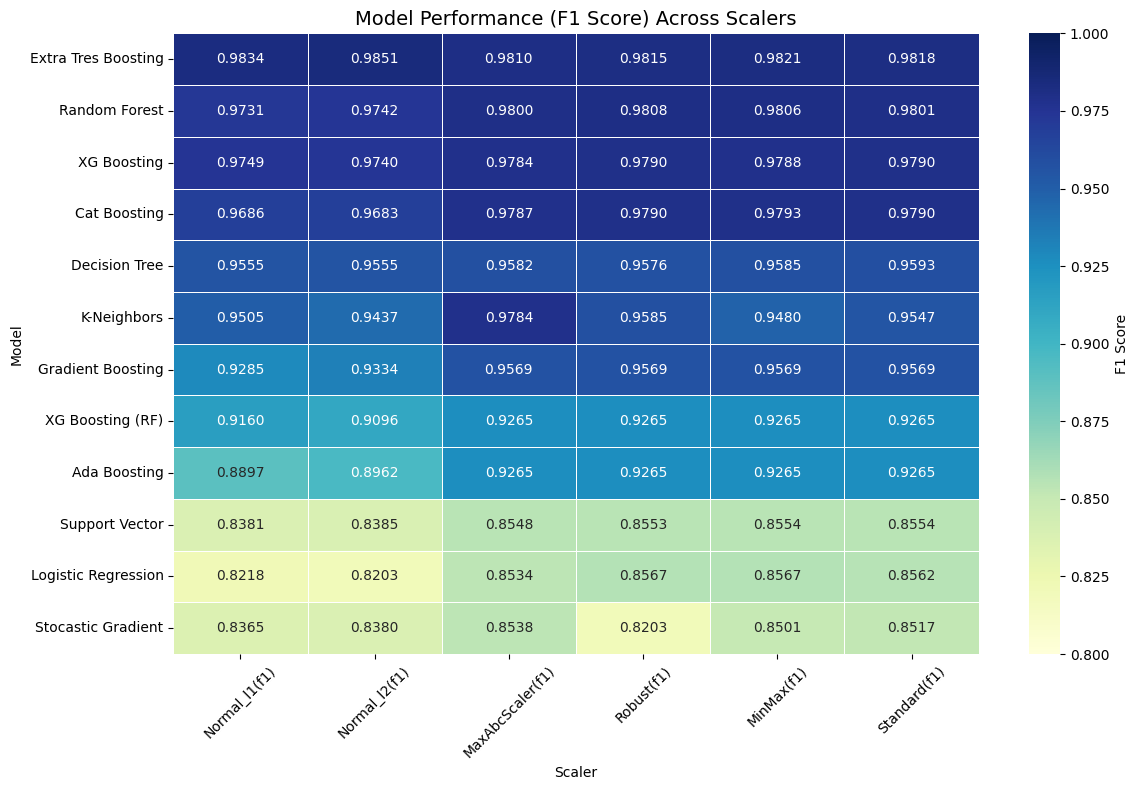

In [181]:
plot_f1_heatmap(models_report1, sort_models=True, save_path=None, title="Model Performance (F1 Score) Across Scalers")

#### **Conclusion:**

In [290]:
get_top_n_model_scaler_scores(models_report1, top_n=10)

,Model,Scaler,Score (%)
0,Extra Tres Boosting,Normal_l2(f1),98.59
1,Extra Tres Boosting,Normal_l1(f1),98.39
2,Extra Tres Boosting,Standard(f1),98.25
3,Extra Tres Boosting,MaxAbcScaler(f1),98.15
4,Extra Tres Boosting,Robust(f1),98.08
5,Extra Tres Boosting,MinMax(f1),98.06
6,Random Forest,MaxAbcScaler(f1),98.02
7,Random Forest,Robust(f1),97.99
8,Random Forest,MinMax(f1),97.94
9,Cat Boosting,MinMax(f1),97.93


### 2. Forward Selected Features

In [291]:
FORWARDS_FEATURE_SELECTION = ['Age_Power', 'Ever_married_encode', 'Work_type_encode',
         'Work_type_children', 'Work_type_govt_job',
         'Work_type_self_employed', 'Residence_type_encode',
         'Smoking_status_never_smoked']

In [292]:
model_selection_obj2 = Model_Selection_Methods(
    X_res[FORWARDS_FEATURE_SELECTION],
    y_res,
    5,
    "f1",
    True
)

In [293]:
print(model_selection_obj1.model_tags)

['LR', 'RDG', 'NB', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'LGB', 'CB']


In [294]:
print(model_selection_obj1.scaler_tags)

['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard']


In [295]:
models_report2 = model_selection_obj2.model_selection(
    ['LR', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'CB'
    ],
    ['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard'],
    True
)

=============== Normal_l1 ===============
Logistic Regression : Mean: 0.8412 Std: 0.0066

Support Vector : Mean: 0.8457 Std: 0.0074

K-Neighbors : Mean: 0.912 Std: 0.0105

Decision Tree : Mean: 0.9452 Std: 0.007

Random Forest : Mean: 0.9493 Std: 0.0055

Stocastic Gradient : Mean: 0.8442 Std: 0.0077

Gradient Boosting : Mean: 0.9203 Std: 0.0067

Ada Boosting : Mean: 0.9061 Std: 0.0056

Extra Tres Boosting : Mean: 0.9519 Std: 0.004

XG Boosting : Mean: 0.9456 Std: 0.0059

XG Boosting (RF) : Mean: 0.9127 Std: 0.0068

Cat Boosting : Mean: 0.9356 Std: 0.0055

=============== Normal_l2 ===============
Logistic Regression : Mean: 0.8366 Std: 0.004

Support Vector : Mean: 0.8302 Std: 0.0034

K-Neighbors : Mean: 0.9052 Std: 0.008

Decision Tree : Mean: 0.9475 Std: 0.0071

Random Forest : Mean: 0.9481 Std: 0.005

Stocastic Gradient : Mean: 0.8364 Std: 0.0071

Gradient Boosting : Mean: 0.9235 Std: 0.0068

Ada Boosting : Mean: 0.9088 Std: 0.0061

Extra Tres Boosting : Mean: 0.951 Std: 0.0047

XG 

#### Plot Performance

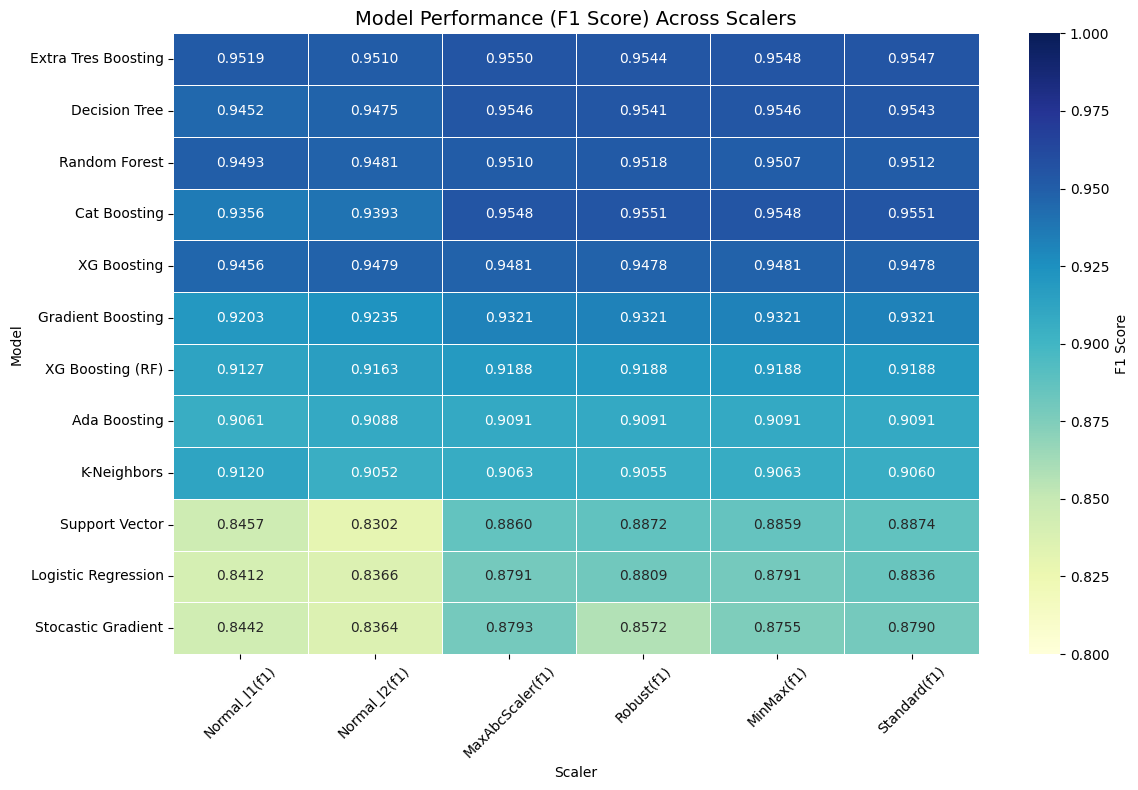

In [296]:
plot_f1_heatmap(models_report2, sort_models=True, save_path=None, title="Model Performance (F1 Score) Across Scalers")

#### **Conclusion:**

In [297]:
get_top_n_model_scaler_scores(models_report2, top_n=10)

,Model,Scaler,Score (%)
0,Cat Boosting,Standard(f1),95.51
1,Cat Boosting,Robust(f1),95.51
2,Extra Tres Boosting,MaxAbcScaler(f1),95.50
3,Extra Tres Boosting,MinMax(f1),95.48
4,Cat Boosting,MaxAbcScaler(f1),95.48
5,Cat Boosting,MinMax(f1),95.48
6,Extra Tres Boosting,Standard(f1),95.47
7,Decision Tree,MaxAbcScaler(f1),95.46
8,Decision Tree,MinMax(f1),95.46
9,Extra Tres Boosting,Robust(f1),95.44


### 3. Backward Selected Features

In [298]:
BACKWARDS_FEATURE_SELECTION = ['Age_Power', 'Avg_glucose_level_Power', 'Gender_encode',
         'Ever_married_encode', 'Work_type_never_worked',
         'Residence_type_encode', 'Smoking_status_formerly_smoked',
         'Smoking_status_never_smoked', 'Smoking_status_smokes']

In [299]:
model_selection_obj3 = Model_Selection_Methods(
    X_res[BACKWARDS_FEATURE_SELECTION],
    y_res,
    5,
    "f1",
    True
)

In [300]:
print(model_selection_obj3.model_tags)

['LR', 'RDG', 'NB', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'LGB', 'CB']


In [301]:
print(model_selection_obj3.scaler_tags)

['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard']


In [302]:
models_report3 = model_selection_obj3.model_selection(
    ['LR', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'CB'
    ],
    ['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard'],
    True
)

=============== Normal_l1 ===============
Logistic Regression : Mean: 0.8381 Std: 0.0043

Support Vector : Mean: 0.8437 Std: 0.0052

K-Neighbors : Mean: 0.8989 Std: 0.0055

Decision Tree : Mean: 0.9307 Std: 0.0052

Random Forest : Mean: 0.9391 Std: 0.0038

Stocastic Gradient : Mean: 0.8426 Std: 0.0059

Gradient Boosting : Mean: 0.9163 Std: 0.0041

Ada Boosting : Mean: 0.9044 Std: 0.004

Extra Tres Boosting : Mean: 0.9357 Std: 0.0046

XG Boosting : Mean: 0.9371 Std: 0.0055

XG Boosting (RF) : Mean: 0.9125 Std: 0.0048

Cat Boosting : Mean: 0.9314 Std: 0.0057

=============== Normal_l2 ===============
Logistic Regression : Mean: 0.8265 Std: 0.0042

Support Vector : Mean: 0.8194 Std: 0.0039

K-Neighbors : Mean: 0.9039 Std: 0.005

Decision Tree : Mean: 0.9322 Std: 0.0031

Random Forest : Mean: 0.9405 Std: 0.0043

Stocastic Gradient : Mean: 0.8348 Std: 0.0157

Gradient Boosting : Mean: 0.9198 Std: 0.0042

Ada Boosting : Mean: 0.902 Std: 0.0057

Extra Tres Boosting : Mean: 0.9354 Std: 0.0039


#### Plot Performance

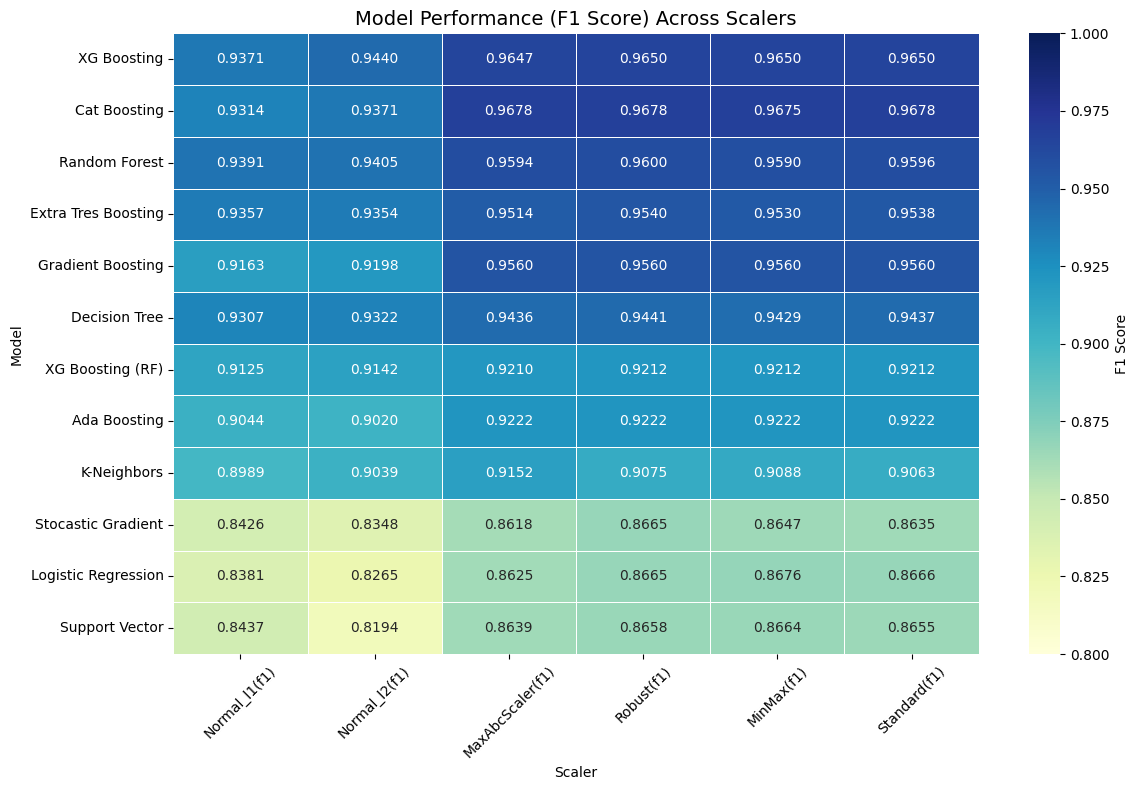

In [303]:
plot_f1_heatmap(models_report3, sort_models=True, save_path=None, title="Model Performance (F1 Score) Across Scalers")

#### **Conclusion:**

In [304]:
get_top_n_model_scaler_scores(models_report3, top_n=10)

,Model,Scaler,Score (%)
0,Cat Boosting,Standard(f1),96.78
1,Cat Boosting,Robust(f1),96.78
2,Cat Boosting,MaxAbcScaler(f1),96.78
3,Cat Boosting,MinMax(f1),96.75
4,XG Boosting,Standard(f1),96.50
5,XG Boosting,MinMax(f1),96.50
6,XG Boosting,Robust(f1),96.50
7,XG Boosting,MaxAbcScaler(f1),96.47
8,Random Forest,Robust(f1),96.00
9,Random Forest,Standard(f1),95.96


### 4. Backward Eliminated Features

In [305]:
BACKWARD_FEATURE_ELIMINATION = ['Age_Power', 'Avg_glucose_level_Power', 'Gender_encode',
         'Ever_married_encode', 'Work_type_encode', 'Work_type_private',
         'Smoking_status_encode', 'Smoking_status_never_smoked']

In [306]:
model_selection_obj4 = Model_Selection_Methods(
    X_res[BACKWARD_FEATURE_ELIMINATION],
    y_res,
    5,
    "f1",
    True
)

In [307]:
print(model_selection_obj4.model_tags)

['LR', 'RDG', 'NB', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'LGB', 'CB']


In [308]:
print(model_selection_obj4.scaler_tags)

['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard']


In [309]:
models_report4 = model_selection_obj4.model_selection(
    ['LR', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'CB'
    ],
    ['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard'],
    True
)

=============== Normal_l1 ===============
Logistic Regression : Mean: 0.8525 Std: 0.0047

Support Vector : Mean: 0.8583 Std: 0.0033

K-Neighbors : Mean: 0.9209 Std: 0.0065

Decision Tree : Mean: 0.9352 Std: 0.0059

Random Forest : Mean: 0.9491 Std: 0.0054

Stocastic Gradient : Mean: 0.8537 Std: 0.0062

Gradient Boosting : Mean: 0.9311 Std: 0.0077

Ada Boosting : Mean: 0.9084 Std: 0.0112

Extra Tres Boosting : Mean: 0.9491 Std: 0.0052

XG Boosting : Mean: 0.9483 Std: 0.006

XG Boosting (RF) : Mean: 0.9175 Std: 0.0052

Cat Boosting : Mean: 0.9461 Std: 0.0064

=============== Normal_l2 ===============
Logistic Regression : Mean: 0.8519 Std: 0.0043

Support Vector : Mean: 0.8491 Std: 0.0033

K-Neighbors : Mean: 0.9261 Std: 0.0066

Decision Tree : Mean: 0.943 Std: 0.0039

Random Forest : Mean: 0.9527 Std: 0.0049

Stocastic Gradient : Mean: 0.8559 Std: 0.0054

Gradient Boosting : Mean: 0.9315 Std: 0.0066

Ada Boosting : Mean: 0.9166 Std: 0.0075

Extra Tres Boosting : Mean: 0.9505 Std: 0.0057

#### Plot Performance

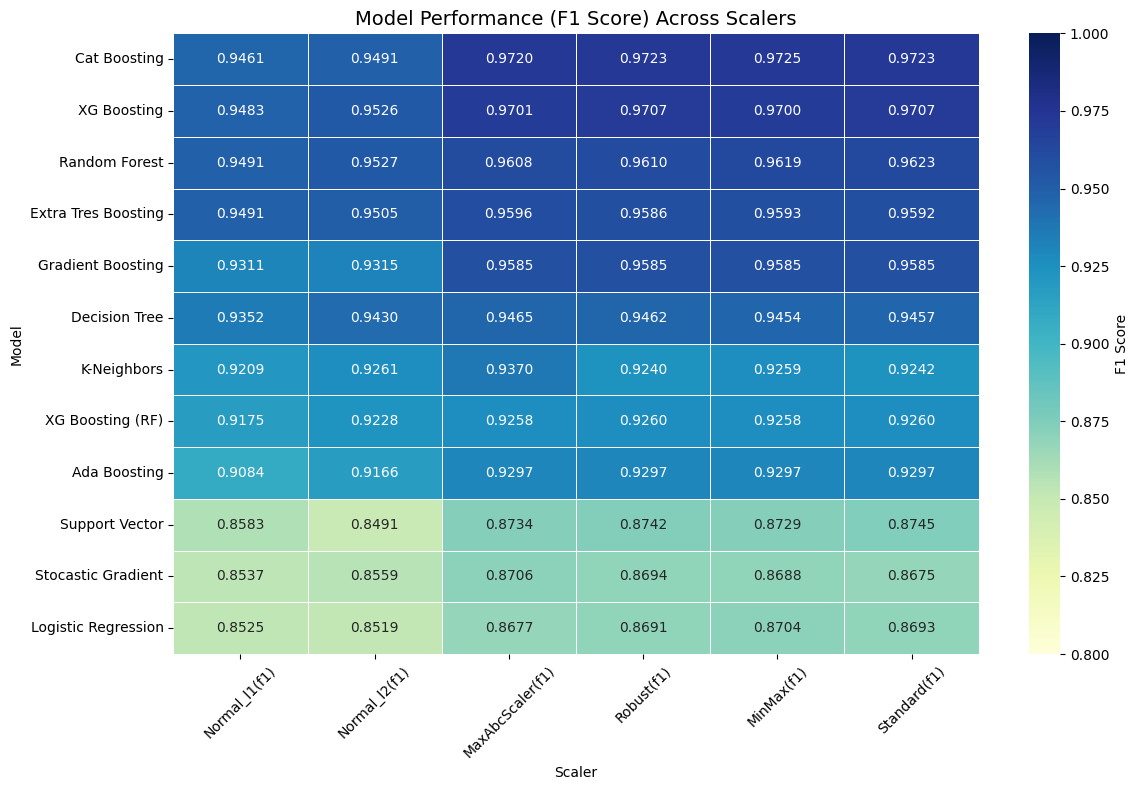

In [310]:
plot_f1_heatmap(models_report4, sort_models=True, save_path=None, title="Model Performance (F1 Score) Across Scalers")

#### **Conclusion:**

In [311]:
get_top_n_model_scaler_scores(models_report4, top_n=10)

,Model,Scaler,Score (%)
0,Cat Boosting,MinMax(f1),97.25
1,Cat Boosting,Standard(f1),97.23
2,Cat Boosting,Robust(f1),97.23
3,Cat Boosting,MaxAbcScaler(f1),97.20
4,XG Boosting,Standard(f1),97.07
5,XG Boosting,Robust(f1),97.07
6,XG Boosting,MaxAbcScaler(f1),97.01
7,XG Boosting,MinMax(f1),97.00
8,Random Forest,Standard(f1),96.23
9,Random Forest,MinMax(f1),96.19


### 5. Embedded Features

In [324]:
EBEDDED_FEATURES = ['Age_Power', 'Avg_glucose_level_Power', 'Bmi_Imputed_median', 'Ever_married_encode', 'Gender_encode', 
'Residence_type_encode', 'Work_type_encode', 'Work_type_children', 'Smoking_status_encode']

In [325]:
model_selection_obj5 = Model_Selection_Methods(
    X_res[EBEDDED_FEATURES],
    y_res,
    5,
    "f1",
    True
)

In [326]:
print(model_selection_obj5.model_tags)

['LR', 'RDG', 'NB', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'LGB', 'CB']


In [327]:
print(model_selection_obj5.scaler_tags)

['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard']


In [328]:
models_report5 = model_selection_obj5.model_selection(
    ['LR', 'SVM', 'KNN', 'DT', 'RF', 'SGD', 'GB', 'AB', 'ETC', 'XGB', 'XGRFB', 'CB'
    ],
    ['Normal_l1', 'Normal_l2', 'MaxAbcScaler', 'Robust', 'MinMax', 'Standard'],
    True
)

=============== Normal_l1 ===============
Logistic Regression : Mean: 0.8279 Std: 0.0034

Support Vector : Mean: 0.8441 Std: 0.0023

K-Neighbors : Mean: 0.9348 Std: 0.0028

Decision Tree : Mean: 0.9454 Std: 0.003

Random Forest : Mean: 0.9644 Std: 0.0037

Stocastic Gradient : Mean: 0.8404 Std: 0.0079

Gradient Boosting : Mean: 0.9136 Std: 0.007

Ada Boosting : Mean: 0.8777 Std: 0.0089

Extra Tres Boosting : Mean: 0.9706 Std: 0.005

XG Boosting : Mean: 0.9598 Std: 0.005

XG Boosting (RF) : Mean: 0.9069 Std: 0.0064

Cat Boosting : Mean: 0.953 Std: 0.0046

=============== Normal_l2 ===============
Logistic Regression : Mean: 0.8234 Std: 0.004

Support Vector : Mean: 0.8436 Std: 0.0038

K-Neighbors : Mean: 0.9272 Std: 0.0038

Decision Tree : Mean: 0.9419 Std: 0.0058

Random Forest : Mean: 0.9676 Std: 0.0016

Stocastic Gradient : Mean: 0.8363 Std: 0.0116

Gradient Boosting : Mean: 0.9185 Std: 0.0032

Ada Boosting : Mean: 0.8845 Std: 0.0048

Extra Tres Boosting : Mean: 0.975 Std: 0.0042

XG 

#### Plot Performance

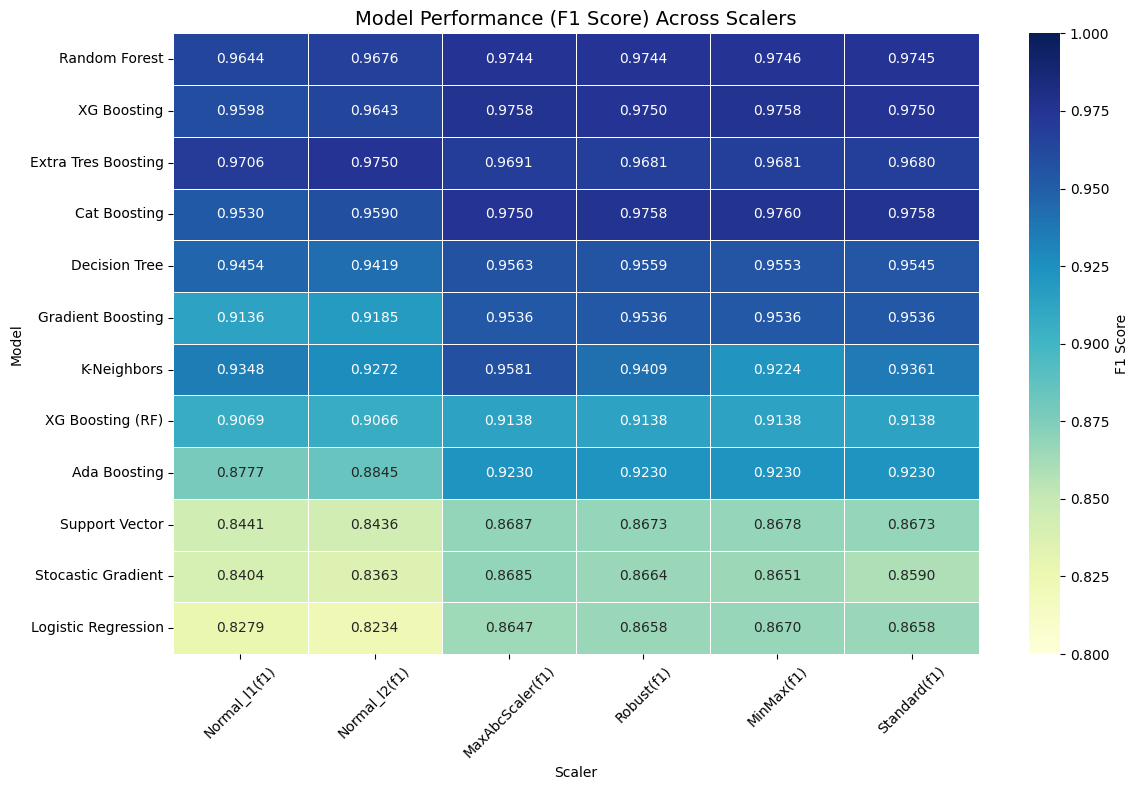

In [329]:
plot_f1_heatmap(models_report5, sort_models=True, save_path=None, title="Model Performance (F1 Score) Across Scalers")

#### **Conclusion:**

In [330]:
get_top_n_model_scaler_scores(models_report5, top_n=10)

,Model,Scaler,Score (%)
0,Cat Boosting,MinMax(f1),97.60
1,Cat Boosting,Standard(f1),97.58
2,Cat Boosting,Robust(f1),97.58
3,XG Boosting,MaxAbcScaler(f1),97.58
4,XG Boosting,MinMax(f1),97.58
5,XG Boosting,Robust(f1),97.50
6,Cat Boosting,MaxAbcScaler(f1),97.50
7,Extra Tres Boosting,Normal_l2(f1),97.50
8,XG Boosting,Standard(f1),97.50
9,Random Forest,MinMax(f1),97.46


## Final Conclusion

No. | Model Selection Methods | Model | Scaler | Score(%)
--- | --- | --- | --- | --- 
1 | Statistically Filttered   | Extra Tres Boosting|	Normal_l2(f1)|	98.59
2 | Forward Fetaure Selection | Cat Boosting|	Standard(f1)|	95.51
3 | Backward Fetaure Selection| Cat Boosting|	Standard(f1)|	96.78
4 | Forward Fetaure Elimination | Cat Boosting|	MinMax(f1)|	97.25
5 | Embedded Features | Cat Boosting|	MinMax(f1)|	97.60